In [9]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

# 03: Base Model Interactions - Friedman's H
Use the trained model to explore interaction measures.  Start with Friedman's H.  Get pairwise interactions for all features.

The sklearn-gbmi package is used for Friedman's H. I had to use the advanced installation instructions (installing and using cython) in https://pypi.org/project/sklearn-gbmi/ .  There are some warnings about scikit-learn compatibility. I am using package versions:
scikit-learn==1.2.0, sklearn-gbmi==1.0.3

*This script takes about 1 minute to run on my MacBook Air*

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pathlib import Path
import sklearn as sk
import time

In [11]:
from sklearn_gbmi import h, h_all_pairs

In [12]:
from interactions_package.interactions_package import ip_plot
ip_plot.plot_defaults()

## Import Data

##### Predictors

In [13]:
predictor_features = pd.read_csv(Path(setup.temp_path) \
                                 .joinpath('01_REPORT_predictor_features.csv')) \
    ['feature'].tolist()

##### Training data - also make sample

In [14]:
train_df = pd.read_parquet(Path(setup.temp_path).joinpath('01_DATA_combined_base_train.parquet'))

In [15]:
train_df.columns

Index(['index', 'id', 'grade', 'sub_grade', 'hardship_flag',
       'debt_settlement_flag', 'hardship_amount', 'settlement_amount',
       'addr_state', 'purpose', 'total_rec_prncp', 'total_rec_int',
       'tot_coll_amt', 'tot_cur_bal', 'application_type', 'loan_amnt', 'term',
       'int_rate', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'fico_range_low', 'sec_app_fico_range_low',
       'open_acc', 'initial_list_status', 'num_actv_bc_tl', 'mort_acc',
       'pub_rec', 'revol_bal', 'target', 'home_ownership__MORTGAGE',
       'home_ownership__RENT', 'home_ownership__OWN',
       'home_ownership__ZZ_OTHER'],
      dtype='object')

In [16]:
# Create a sample to use for all the measures
train_samp_df = train_df.sample(100000, random_state = 555)

In [17]:
train_samp_df.to_parquet(Path(setup.temp_path).joinpath('03_DATA_combined_base_train_samp.parquet'))

##### Model

In [18]:
with open(Path(setup.temp_path).joinpath('02_MODEL_base_gc.pkl'), 'rb') as pi:
    base_model = pickle.load(pi)

##### Permutation importances

In [19]:
perm_importance_df = pd.read_csv(Path(setup.temp_path).joinpath('02_DATA_importance_perturb.csv'))

## Pairwise Friedman H
Get pairwise Friedman interactions among all features.

In [11]:
hap = h_all_pairs(base_model, train_samp_df[predictor_features],
                 perm_importance_df['features'].tolist())

In [12]:
top_feat = perm_importance_df.head(10)['features'].tolist()
print(top_feat)

['int_rate', 'term', 'loan_amnt', 'annual_inc', 'home_ownership__RENT', 'sec_app_fico_range_low', 'num_actv_bc_tl', 'open_acc', 'revol_bal', 'verification_status']


In [13]:
# Get interactions - time the call
t_init = time.process_time()
hap = h_all_pairs(base_model, train_samp_df[predictor_features], top_feat)
t_delta_hap = time.process_time() - t_init
print(t_delta_hap)

43.984365


In [14]:
# Convert to data frame
hap_df = pd.DataFrame({'feat_1': [k[0] for k in hap.keys()], 
              'feat_2': [k[1] for k in hap.keys()],
              'h_score': hap.values()}) \
    .sort_values('h_score', ascending=False)

##### Save Data

In [15]:
hap_df['label'] = hap_df['feat_1'] + ':' + hap_df['feat_2']

In [16]:
hap_df.to_csv(Path(setup.temp_path).joinpath('03_DATA_h_scores.csv'), index=False)

In [17]:
# save the time
time_df = pd.DataFrame({'time':[t_delta_hap],
                        'feature_count': [len(predictor_features)],
                        'case_count': [len(train_samp_df)]})
time_df['time_per_case'] = time_df['time'] / time_df['case_count']
time_df.to_csv(Path(setup.temp_path).joinpath('03_REPORT_timing_h_scores.csv'))
time_df

,time,feature_count,case_count,time_per_case
0,43.984365,18,100000,0.00044


## Plots

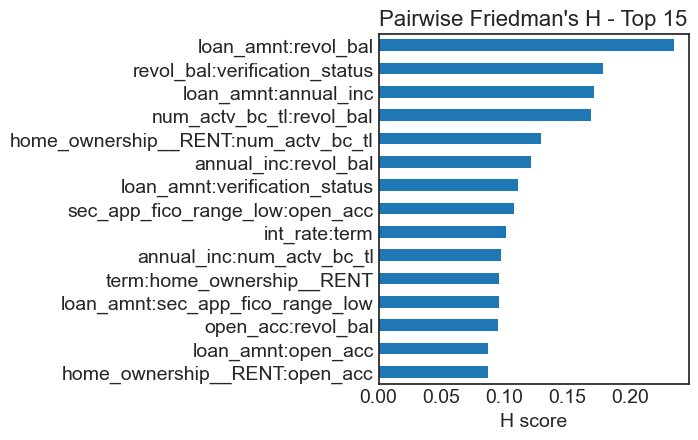

In [18]:
fig = setup.plot_basic_bar(hap_df, 'h_score', n_bars=15, 
                           label='label', title="Pairwise Friedman's H - Top 15",
                           ylabel='H score')
fig.savefig(Path(setup.temp_path).joinpath('03_PLOT_h_score_pairs.png'),
                 bbox_inches='tight')

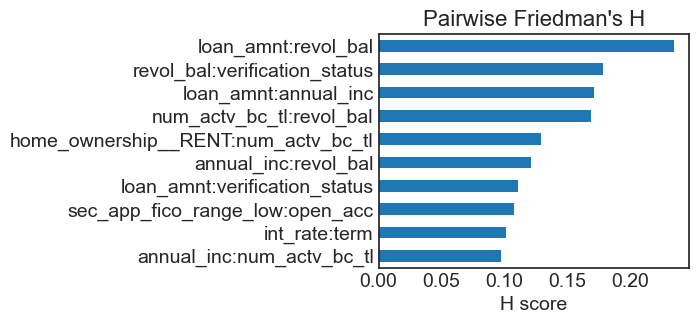

In [19]:
# Get just the top 10
fig = setup.plot_basic_bar(hap_df, 'h_score', label='label', 
                           title="Pairwise Friedman's H", ylabel='H score')
fig.savefig(Path(setup.temp_path).joinpath('03_PLOT_h_score_pairs_top_10.png'),
                 bbox_inches='tight')

##### Plot interactions with interest rate

In [20]:
# Function to plot only interactions involving a selected feature
def plot_interactions_feat(data, feat = 'int_rate',
                          save_path=None, n_bars = 15):
    # Get the feature's interaction from pairwise data
    selected_interactions = data[(data['feat_1'] == feat) |
                                (data['feat_2'] == feat)] \
        .melt(id_vars='h_score', value_vars=['feat_1', 'feat_2']) \
        .groupby('value')['h_score'] \
        .agg('max') \
        .sort_values(ascending=False)
    selected_interactions = \
        selected_interactions[selected_interactions.index != feat] \
        .sort_values(ascending=False)
    
    # plot
    fig = setup.plot_basic_bar(pd.DataFrame(selected_interactions), 'h_score',
                               n_bars = n_bars, ylabel= 'H score',
                               title='Interactions with ' + feat)
    if save_path is not None:
        fig.savefig(save_path, bbox_inches='tight')
    
    return fig

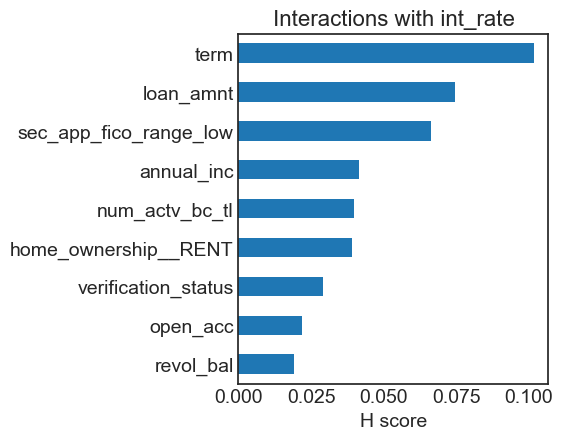

In [21]:
_ = plot_interactions_feat(hap_df,
                      save_path = Path(setup.temp_path) \
                       .joinpath('03_PLOT_h_score_w_int_rate.png'))

##### Plot interactions with sec_app_fico_range_low

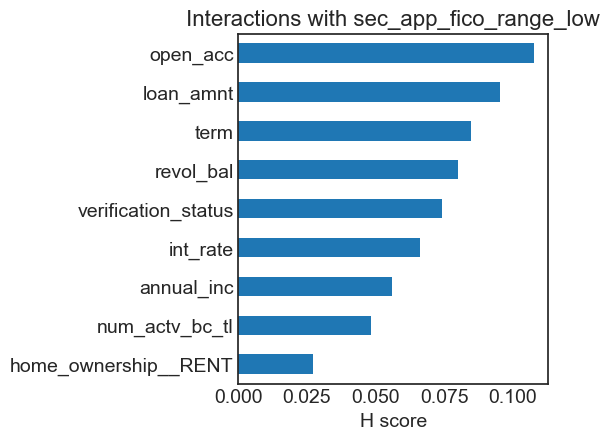

In [22]:
_ = plot_interactions_feat(hap_df, 'sec_app_fico_range_low',
                      save_path = Path(setup.temp_path) \
                       .joinpath('03_PLOT_h_score_w_int_rate.png'))

##### Plot max H per feature

In [23]:
feat_max_h = hap_df \
    .melt(id_vars='h_score', value_vars=['feat_1', 'feat_2']) \
    .groupby('value')['h_score'] \
    .agg('max') \
    .sort_values(ascending=False)

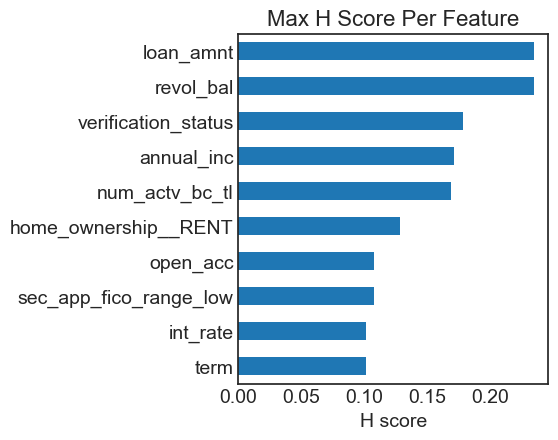

In [24]:
# Get just the top 10
fig = setup.plot_basic_bar(pd.DataFrame(feat_max_h), 'h_score', n_bars = 15,
                           title="Max H Score Per Feature", ylabel='H score')
fig.savefig(Path(setup.temp_path).joinpath('03_PLOT_h_score_max.png'),
                 bbox_inches='tight')

## Vary Sample Size 
Try a few different samples from the training data of different sizes.

In [25]:
samp_size_list = [10, 50, 100, 500, 1000]

In [26]:
h_vals_vary = [[s, h(base_model, train_samp_df \
                     .sample(int(s))[predictor_features], 
      ['int_rate', 'term'])] for s in samp_size_list \
 for i in range (0, 10)]

In [27]:
h_vals_vary_df = pd.DataFrame(h_vals_vary) \
    .set_axis(['size', 'h_val'], axis=1)

In [28]:
h_vals_agg = h_vals_vary_df.groupby('size')['h_val'] \
    .agg(['mean', 'std']) 

In [29]:
h_vals_agg.to_csv(Path(setup.temp_path) \
                       .joinpath('03_REPORT_h_sample_size_variance.csv'), index=True)

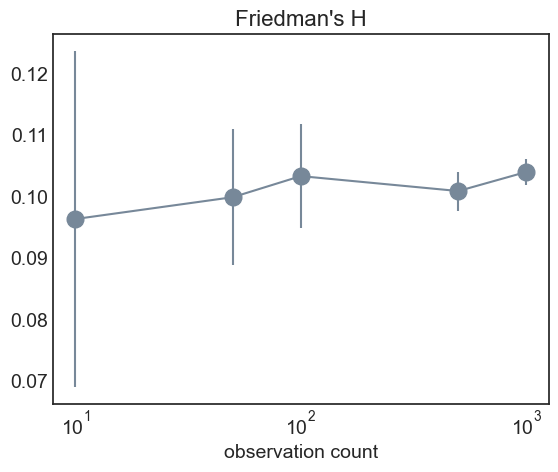

In [30]:
fig, ax = plt.subplots()
h_vals_agg.plot(y='mean', yerr='std', markersize=12, style='o-', ax=ax, 
                legend=None, color='lightslategray')
h_vals_agg.plot(y='mean', markersize=12, style='o', ax=ax, 
                legend=None, color='lightslategray')
plt.xscale('log')
plt.title("Friedman's H")
ax.set_xlabel('observation count')
#plt.axhline(y=0, color='black')
plt.gcf().savefig(Path(setup.temp_path).joinpath('03_PLOT_h_variance_with_sample_size.png'),
                  bbox_inches='tight')
plt.show()